In [1]:
import pandas as pd
import ast
from nltk.tokenize import word_tokenize, sent_tokenize
import numpy as np

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
import logging
from transformers import logging as hf_logging

full_data = pd.read_csv('/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv')

pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=737bf284c0e72fb3f8fdcc80f00f2301cae2f0b2a83f1f0522247e17b94534ec
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [2]:
# Data Preprocessing
imp_data = full_data[['id', 'overview', 'title', 'keywords']].dropna(subset=['overview'])
imp_data = imp_data[imp_data['overview'] != '']

summaries_small = imp_data['overview'][:4000].reset_index(drop=True)
titles_small = imp_data['title'][:4000].reset_index(drop=True)
ids_small = imp_data['id'].reset_index(drop=True)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# skip-gram on Google News data
from nltk.data import find
import gensim
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

# now we can find embedding of each word with model[<word>]

# expects a list of summaries
def tokenize_and_embed_data(raw_data):
    data = []
    for summary in raw_data:
        summ = []
        for sentence in sent_tokenize(summary):
            sent = []
            for word in word_tokenize(sentence):
                word = str.lower(word)
                if word in model:
                    embedding = model[word]
                    sent.append(embedding)
            if sent:
                avg_sent_embed = np.mean(sent, axis=0)
                summ.append(avg_sent_embed)
        if summ:
            avg_summ_embed = np.mean(summ, axis=0)
            data.append(avg_summ_embed)
    return data

# tokenize and embed data
processed_data = tokenize_and_embed_data(summaries_small)

In [4]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import davies_bouldin_score

number_of_clusters = 1000
# Perform clustering with Spectral
clustering = SpectralClustering(n_clusters=number_of_clusters, assign_labels='discretize',random_state=7).fit(processed_data)

# Assign labels to data points
labels = clustering.labels_

# Compute Davies-Bouldin Index
db_score = davies_bouldin_score(processed_data, labels)

print('Davies-Bouldin Index: ', db_score)

Davies-Bouldin Index:  2.8557117572185295


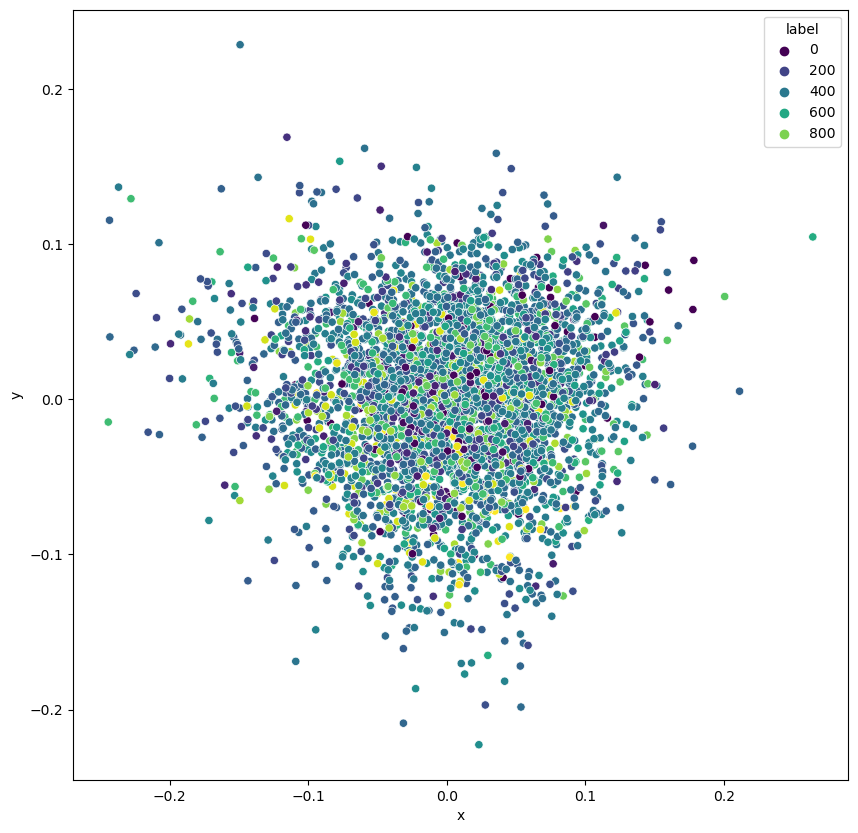

Cluster 0 summaries:
          ID                              Title                                            Summary
101    49538                 X-Men: First Class  Before Charles Xavier and Erik Lensherr took t...
117      118  Charlie and the Chocolate Factory  A young boy wins a tour through the most magni...
156      616                   The Last Samurai  Nathan Algren is an American hired to instruct...
162    10048                            Stealth  Deeply ensconced in a top-secret military prog...
236    12100                        Windtalkers  Joe Enders is a gung-ho Marine assigned to pro...
256   262504                          Allegiant  Beatrice Prior and Tobias Eaton venture into t...
439    11324                     Shutter Island  World War II soldier-turned-U.S. Marshal Teddy...
456   228150                               Fury  Last months of World War II in April 1945. As ...
468     9705                          Swordfish  Rogue agent Gabriel Shear is determined

In [5]:
# PCA for dimension reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(processed_data)

# Create a DataFrame for easy plotting
df = pd.DataFrame(reduced_data, columns=['x', 'y'])
df['label'] = clustering.labels_
df['Title'] = titles_small
df['Summary'] = summaries_small
df['ID'] = ids_small

# print(df)

# Plot using seaborn
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y', hue='label', palette='viridis', legend=True)
plt.show()

pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 50)

# Print out summaries from each cluster
for i in range(number_of_clusters):  # Change this range depending on which clusters you want to look at
    print(f'Cluster {i} summaries:')
    print(df[df['label'] == i][['ID', 'Title', 'Summary']])
    print('\n')

In [6]:
cluster_counts = df['label'].value_counts()
largest_cluster = cluster_counts.idxmax()
largest_cluster_size = cluster_counts.max()

print(f"The largest cluster is: {largest_cluster} with size: {largest_cluster_size}")

The largest cluster is: 0 with size: 40
